In [1]:
import pandas as pd
import sys
from pyspark.sql import types as T
from pyspark.sql import functions as F

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Test_spark").master("local[*]").getOrCreate()
spark

# Leer dataset spark

In [6]:
ruta="C:/Users/Aitor/Desktop/datos_mod_cab/"
archivo = "final_dataset.csv"

In [37]:
customSchema = [T.StructField("user_ID", T.IntegerType()), 
    T.StructField("attemp", T.IntegerType()),
    T.StructField("time(us)", T.LongType()), 
    T.StructField("accX(g)", T.DoubleType()),
    T.StructField("accY(g)", T.DoubleType()),
    T.StructField("accZ(g)", T.DoubleType()),
    T.StructField("gyrX(o/s)", T.DoubleType()),
    T.StructField("gyry(o/s)", T.DoubleType()),
    T.StructField("gyrz(o/s)", T.DoubleType())]
customSchema=T.StructType(customSchema)

In [44]:
df = spark.read.option("sep",",").option("header","true").option("mode","DROPMALFORMED").schema(customSchema).csv(ruta+archivo)

In [45]:
df.printSchema()

root
 |-- user_ID: integer (nullable = true)
 |-- attemp: integer (nullable = true)
 |-- time(us): long (nullable = true)
 |-- accX(g): double (nullable = true)
 |-- accY(g): double (nullable = true)
 |-- accZ(g): double (nullable = true)
 |-- gyrX(o/s): double (nullable = true)
 |-- gyry(o/s): double (nullable = true)
 |-- gyrz(o/s): double (nullable = true)



# Leer dataset pandas

In [7]:
ruta="C:/Users/Aitor/Desktop/TFM/datos_mod_cab/"
archivo = "final_dataset.csv"

In [8]:
dataset = pd.read_csv(ruta+archivo, header=0)
dataset.head(5)
#dataset.describe()

,user_ID,attemp,time(us),accX(g),accY(g),accZ(g),gyrX(o/s),gyry(o/s),gyrz(o/s)
0,1,1,0,1.009766,-0.016602,0.016602,0.900763,0.152672,-0.778626
1,1,1,1661,1.009277,-0.020020,0.031250,1.007634,-0.015267,-0.580153
2,1,1,3333,1.006348,-0.018555,0.026855,0.809160,0.045802,-0.625954
3,1,1,4994,1.014648,-0.010254,0.034668,0.900763,-0.152672,-0.625954
4,1,1,6655,1.015137,-0.016602,0.021484,0.687023,0.259542,-0.916031


# Entrenamiento con LSTM

In [9]:
def create_dataset(dataset, historia):
	dataX, dataY = [], []
	for i in range(len(dataset)-historia-1):
		a = dataset[i:(i+historia), 0]
		dataX.append(a)
		dataY.append(dataset[i + historia, 0])
	return np.array(dataX), np.array(dataY)

# Fijamos la semilla para generar números aleatorios, para controlar la aleatoriedad.
np.random.seed(7)

# Cargamos los datos (la columna del id del usuario)
dataframe = dataset.iloc [:,0]
dataset0 = dataframe.values
dataset0 = dataset0.astype('float32')
#dataset = dataset0.reshape (-1,1)

# Normalizamos los datos entre 0 y 1
#scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(dataset)

# Dividimos el conjunto entre entrenamiento y prueba.
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]
# Fijamos algunos parámetros que vamos a usar de forma global más tarde.

EPOCAS=10
LSTM_dim=2
historia=9

TypeError: '(slice(0, 941551, None), slice(None, None, None))' is an invalid key

In [15]:
# Separa los datos de (entrenamiento, prueba) en la parte de entrada y de salida.

trainX, trainY = create_dataset(train, historia)
testX, testY = create_dataset(test, historia)
print(trainY)
# Los datos de entrada a una capa LSTM tienen que ser un tensor con
# la siguiente forma [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#print ("Forma de entrenamiento: ", trainX.shape, trainY.shape)
#print ("Forma de prueba       : ", testX.shape, testY.shape)
# Desnormaliza
testY2 = scaler.inverse_transform([testY])
testY3 = testY2.reshape(-1,1)

[0.         0.         0.         ... 0.67391306 0.67391306 0.67391306]
[[[0.         0.         0.        ]]

 [[0.         0.         0.        ]]

 [[0.         0.         0.        ]]

 ...

 [[0.67391306 0.67391306 0.67391306]]

 [[0.67391306 0.67391306 0.67391306]]

 [[0.67391306 0.67391306 0.67391306]]]


In [73]:
def ModeloSencillo (npeh):
    LSTM_dim=npeh
    # Crea el modelo
    model = tf.keras.Sequential()
    model.add(LSTM(LSTM_dim, input_shape=(1, historia)))
    model.add(Dense(3))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=10, verbose=0)
    return model

# Vamos a entrenar 5 veces con distintas semillas aleatorias
# Recogeremos el resultado (rmse)


Resultados=pd.DataFrame(columns=('NumPEH','Semilla', 'RMSE'))

# Buscaremos el valor óptimo en cuanto el número de
# elementos de proceso en la capa oculta (la capa LSTM)
for npeh in  (2,4):

    # Debido a la inicialización aleatoria de los pesos antes del proceso 
    # de entrenamiento, es necesario repetir el entrenamiento varias veces,
    # cada vez con una inicialización distinta.
    # Haremos una estimación de la eficiencia del modelo (la red neuronal con el número de elementos de
    # proceso en la capa oculta npeh indicado) calculando el valor medio de la eficiencia de
    # cada uno de los modelos creados con las diferentes semillas.
    
    for seed in range (0,5):

        tf.random.set_seed (seed)
        model=ModeloSencillo (npeh)
    
        # Hace predicciones
        testPredict = model.predict(testX)

        # Desnormaliza las salidas de la red para poder 
        # visualizar correctamente.
        testPredict = scaler.inverse_transform(testPredict)

        # Cálculo del error cuadrático medio.
        testScore = math.sqrt(mean_squared_error(testY2[0], testPredict[:,0]))
        print("Npeh: ", npeh, "Semilla: ", seed, "RMSE: ",testScore)
        Resultados=Resultados.append ({'NumPEH':npeh, 'Semilla':seed, 'RMSE':testScore}, ignore_index=True)

Npeh:  2 Semilla:  0 RMSE:  0.320869759446606
Npeh:  2 Semilla:  1 RMSE:  0.409685995506311
Npeh:  2 Semilla:  2 RMSE:  0.39014931124333907


KeyboardInterrupt: 

In [10]:
print ("Todos los resultados:\n", Resultados)
print ("\nEstimación del RMSE para cada modelo:\n")
print (Resultados.groupby ('NumPEH').RMSE.mean())

Todos los resultados:
    NumPEH  Semilla      RMSE
0     2.0      0.0  0.403626
1     2.0      1.0  0.362416
2     2.0      2.0  0.420646
3     2.0      3.0  0.276209
4     2.0      4.0  0.412585
5     4.0      0.0  0.290031
6     4.0      1.0  0.343386
7     4.0      2.0  0.240252
8     4.0      3.0  0.161198
9     4.0      4.0  0.259755

Estimación del RMSE para cada modelo:

NumPEH
2.0    0.375096
4.0    0.258924
Name: RMSE, dtype: float64


In [14]:
tf.random.set_seed (3)
model=ModeloSencillo (4)

In [15]:
# Hace predicciones
testPredict = model.predict(testX)

# Desnormaliza las salidas reales y de la red para poder 
# visualizar temperaturas correctamente.
testPredict = scaler.inverse_transform(testPredict)
testY2 = scaler.inverse_transform([testY])

# Cálculo del error cuadrático medio.
testScore = math.sqrt(mean_squared_error(testY2[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.16 RMSE


# Otra clasificación sin LSTM

In [33]:
# multi-class classification with Keras
import pandas
from tensorflow import keras
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [65]:
# load dataset
ruta="C:/Users/Aitor/Desktop/TFM/"
archivo = "3_cols_dataset.csv"
X = dataset[:,0:2].astype(float)
Y = dataset[:,0]

[[ 1.000000e+00]
 [ 1.009766e+00]
 [ 1.660200e-02]
 ...
 [ 4.700000e+01]
 [ 1.009277e+00]
 [-1.513700e-02]]


In [62]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [63]:
# define baseline model
def baseline_model():
	# create model
	model = tf.keras.Sequential()
	model.add(Dense(15, input_dim=3, activation='relu'))
	model.add(Dense(47, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [64]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

C:\Users\Aitor\anaconda3\envs\env_TFM\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Aitor\anaconda3\envs\env_TFM\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 220, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 163, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py", line 1183, in fit
    tmp_logs = self.train_function(iter

C:\Users\Aitor\anaconda3\envs\env_TFM\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Aitor\anaconda3\envs\env_TFM\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 220, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 163, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py", line 1183, in fit
    tmp_logs = self.train_function(iter

C:\Users\Aitor\anaconda3\envs\env_TFM\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Aitor\anaconda3\envs\env_TFM\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 220, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 163, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py", line 1183, in fit
    tmp_logs = self.train_function(iter

C:\Users\Aitor\anaconda3\envs\env_TFM\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Aitor\anaconda3\envs\env_TFM\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 220, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 163, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py", line 1183, in fit
    tmp_logs = self.train_function(iter

C:\Users\Aitor\anaconda3\envs\env_TFM\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Aitor\anaconda3\envs\env_TFM\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 220, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 163, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py", line 1183, in fit
    tmp_logs = self.train_function(iter

Baseline: nan% (nan%)


C:\Users\Aitor\anaconda3\envs\env_TFM\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Aitor\anaconda3\envs\env_TFM\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 220, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 163, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\Aitor\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py", line 1183, in fit
    tmp_logs = self.train_function(iter

# Otra clasificacion


In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [47]:
# Importamos los datos de entrenamiento y los de prueba
ruta="C:/Users/Aitor/Desktop/TFM/datos_mod_cab/"
fichero_entrenamiento = "final_dataset.csv"
fichero_prueba = "prueba_1_int_final.csv"

In [48]:
# Random seed for reproducibility
seed = 10
np.random.seed(seed)
# Import data
df = pd.read_csv(ruta+fichero_entrenamiento, header=0)
# Print first 10 samples
print(df.head(10))

   user_ID  attemp  time(us)   accX(g)   accY(g)   accZ(g)  gyrX(o/s)  \
0        1       1         0  1.009766 -0.016602  0.016602   0.900763   
1        1       1      1661  1.009277 -0.020020  0.031250   1.007634   
2        1       1      3333  1.006348 -0.018555  0.026855   0.809160   
3        1       1      4994  1.014648 -0.010254  0.034668   0.900763   
4        1       1      6655  1.015137 -0.016602  0.021484   0.687023   
5        1       1      8318  1.012695 -0.018066  0.017578   0.809160   
6        1       1      9979  1.013672 -0.018555  0.028809   0.946565   
7        1       1     11641  1.007324 -0.017578  0.012695   0.900763   
8        1       1     13302  1.005859 -0.018555  0.015137   0.702290   
9        1       1     14963  1.001953 -0.020020  0.027344   1.038168   

   gyry(o/s)  gyrz(o/s)  
0   0.152672  -0.778626  
1  -0.015267  -0.580153  
2   0.045802  -0.625954  
3  -0.152672  -0.625954  
4   0.259542  -0.916031  
5   0.137405  -0.824427  
6   0.229008  

In [52]:
# Divide data into features X and target (Classes) Y
X = df.iloc[:,3:9]
Y = df.iloc[:,0]
print(X,Y)

          accX(g)   accY(g)   accZ(g)  gyrX(o/s)  gyry(o/s)  gyrz(o/s)
0        1.009766 -0.016602  0.016602   0.900763   0.152672  -0.778626
1        1.009277 -0.020020  0.031250   1.007634  -0.015267  -0.580153
2        1.006348 -0.018555  0.026855   0.809160   0.045802  -0.625954
3        1.014648 -0.010254  0.034668   0.900763  -0.152672  -0.625954
4        1.015137 -0.016602  0.021484   0.687023   0.259542  -0.916031
...           ...       ...       ...        ...        ...        ...
1405295  1.012695  0.034180 -0.002441   1.053435  -0.122137  -0.549618
1405296  1.009277  0.024414 -0.003906   0.854962   0.061069  -0.595420
1405297  1.018066  0.027344 -0.012695   0.656489   0.000000  -0.824427
1405298  1.011230  0.025391  0.003906   0.763359   0.137405  -0.671756
1405299  1.009277  0.021484 -0.015137   0.748092   0.076336  -0.488550

[1405300 rows x 6 columns] 0           1
1           1
2           1
3           1
4           1
           ..
1405295    47
1405296    47
1405297 

In [53]:
# Statistical summary of the variables
print(X.describe())

            accX(g)       accY(g)       accZ(g)     gyrX(o/s)     gyry(o/s)  \
count  1.405300e+06  1.405300e+06  1.405300e+06  1.405300e+06  1.405300e+06   
mean   9.675167e-01 -1.702909e-01  1.718306e-02  8.716722e-01  4.921452e-02   
std    5.337054e-01  2.643577e-01  2.076064e-01  4.270605e+00  1.050591e+01   
min   -1.593848e+01 -1.027734e+01 -1.501758e+01 -3.602290e+02 -4.930992e+02   
25%    8.828120e-01 -4.663090e-01 -3.418000e-03  5.496180e-01 -2.290080e-01   
50%    1.005859e+00 -2.246100e-02  1.611300e-02  8.702290e-01  4.580200e-02   
75%    1.014648e+00  6.348000e-03  3.564500e-02  1.114504e+00  2.900760e-01   
max    1.599951e+01  8.896484e+00  1.548096e+01  1.594504e+02  4.930534e+02   

          gyrz(o/s)  
count  1.405300e+06  
mean  -7.559592e-01  
std    6.357781e+01  
min   -4.528092e+02  
25%   -1.175573e+00  
50%   -7.633590e-01  
75%   -5.343510e-01  
max    4.970076e+02  


In [15]:
# Check for class imbalance
print(df.groupby(Y).size())

user_ID
1     29900
2     29900
3     29900
4     29900
5     29900
6     29900
7     29900
8     29900
9     29900
10    29900
11    29900
12    29900
13    29900
14    29900
15    29900
16    29900
17    29900
18    29900
19    29900
20    29900
21    29900
22    29900
23    29900
24    29900
25    29900
26    29900
27    29900
28    29900
29    29900
30    29900
31    29900
32    29900
33    29900
34    29900
35    29900
36    29900
37    29900
38    29900
39    29900
40    29900
41    29900
42    29900
43    29900
44    29900
45    29900
46    29900
47    29900
dtype: int64


In [58]:
# Normalize features within range 0 (minimum) and 1 (maximum)
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X = pd.DataFrame(X)

In [59]:
# Convert target Y to one hot encoded Y for Neural Network
Y = pd.get_dummies(Y)
# If target is in string form, use following code:
# First encode target values as integers from string
# Then perform one hot encoding
# encoder = LabelEncoder()
# encoder.fit(Y)
# Y = encoder.transform(Y)
# Y = np_utils.to_categorical(Y)

In [60]:
# For Keras, convert dataframe to array values (Inbuilt requirement of Keras)
X = X.values
Y = Y.values

In [69]:
# First define baseline model. Then use it in Keras Classifier for the training
def baseline_model():
    # Create model here
    model = Sequential()
    model.add(Dense(64, activation = 'relu')) # Rectified Linear Unit Activation Function
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(47, activation = 'softmax')) # Softmax for multi-class classification
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [70]:
# Create Keras Classifier and use predefined baseline model
estimator = KerasClassifier(build_fn = baseline_model, epochs = 8, batch_size = 254, verbose = 0)
# Try different values for epoch and batch size

In [71]:
# KFold Cross Validation
kfold = KFold(n_splits = 10, shuffle = True, random_state = seed)

In [72]:
# Object to describe the result
results = cross_val_score(estimator, X, Y, cv = kfold)
# Result
print("Result: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Result: 99.71% (0.06%)


# Clasificacion red neuronal

In [6]:
# multi-class classification with Keras
import pandas
from tensorflow import keras
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [24]:
# Importamos los datos de entrenamiento y los de prueba
ruta="C:/Users/Aitor/Desktop/TFM/"
fichero_entrenamiento = "entrenamiento_10_int_final.csv"
fichero_prueba = "prueba_2_int_final.csv"

df_train = pd.read_csv(ruta+fichero_entrenamiento, header=0)
df_prueba = pd.read_csv(ruta+fichero_prueba, header=0)

In [25]:
print(df_train.shape,df_prueba.shape)

(702650, 4) (140530, 4)


In [26]:
dataset = df_train.values
dataset_prueba = df_prueba.values

X = dataset[:,0:4].astype(float)
Y = dataset[:,0]

x_prueba = dataset_prueba[:,0:4].astype(float)
y_prueba = dataset_prueba[:,0]

In [27]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [28]:
print(X,dummy_y)

[[ 1.        1.        1.009766 -0.778626]
 [ 1.        1.        1.009277 -0.580153]
 [ 1.        1.        1.006348 -0.625954]
 ...
 [47.       10.        1.019043 -0.70229 ]
 [47.       10.        1.008301 -0.564885]
 [47.       10.        0.995605 -0.625954]] [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [29]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_prueba)
encoded_Y = encoder.transform(y_prueba)
# convert integers to dummy variables (i.e. one hot encoded)
y_prueba = np_utils.to_categorical(encoded_Y)

In [20]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_prueba)
encoded_Y = encoder.transform(y_prueba)
# convert integers to dummy variables (i.e. one hot encoded)
y_final_prueba = np_utils.to_categorical(encoded_Y)

In [35]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(47, activation='softmax'))

In [36]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [37]:
history = model.fit(X,
dummy_y,
epochs=10,
batch_size=512,
validation_data=(x_prueba, y_prueba))

Epoch 1/10
1373/1373 [==============================] - 34s 24ms/step - loss: 2.6021 - accuracy: 0.2357 - val_loss: 1.9149 - val_accuracy: 0.3339
Epoch 2/10
1373/1373 [==============================] - 5s 3ms/step - loss: 1.4457 - accuracy: 0.5672 - val_loss: 1.1281 - val_accuracy: 0.6543
Epoch 3/10
1373/1373 [==============================] - 5s 4ms/step - loss: 0.9149 - accuracy: 0.7572 - val_loss: 0.7719 - val_accuracy: 0.7912
Epoch 4/10
1373/1373 [==============================] - 5s 4ms/step - loss: 0.6339 - accuracy: 0.8549 - val_loss: 0.5493 - val_accuracy: 0.8581
Epoch 5/10
1373/1373 [==============================] - 4s 3ms/step - loss: 0.4640 - accuracy: 0.9116 - val_loss: 0.4098 - val_accuracy: 0.9197
Epoch 6/10
1373/1373 [==============================] - 4s 3ms/step - loss: 0.3536 - accuracy: 0.9456 - val_loss: 0.3295 - val_accuracy: 0.9243
Epoch 7/10
1373/1373 [==============================] - 5s 4ms/step - loss: 0.2725 - accuracy: 0.9630 - val_loss: 0.2619 - val_accurac

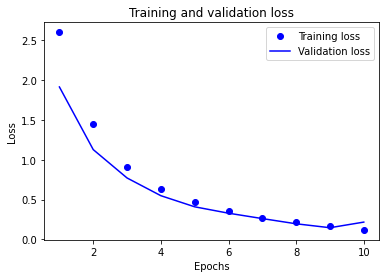

In [38]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

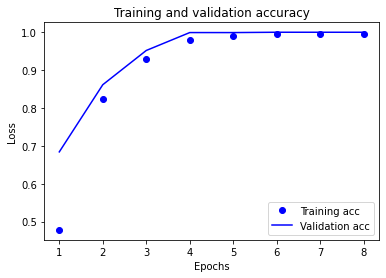

In [35]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
results = model.evaluate(x_prueba, y_final_prueba)

4392/4392 [==============================] - 4s 915us/step - loss: 0.0051 - accuracy: 0.9999


In [28]:
results

[0.005145743023604155, 0.9999359846115112]